In [13]:
import pandas as pd
import numpy as np
df = pd.read_csv("../mammografie.csv")

Informazioni sul database

In [14]:
print("DataFrame Info:")
df.info()
print("\nPrime righe:")
df.head()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        331 non-null    object 
 1   Tissue    330 non-null    object 
 2   Class     330 non-null    object 
 3   Severity  123 non-null    object 
 4   X         122 non-null    object 
 5   Y         122 non-null    object 
 6   Radius    119 non-null    float64
dtypes: float64(1), object(6)
memory usage: 18.2+ KB

Prime righe:


,ID,Tissue,Class,Severity,X,Y,Radius
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477,133,30.0


In [15]:
conteggio_classi = df['Class'].value_counts()
print(conteggio_classi)

Class
NORM    207
CALC     30
CIRC     25
ARCH     19
SPIC     19
MISC     15
ASYM     15
Name: count, dtype: int64


Analisi su Radius

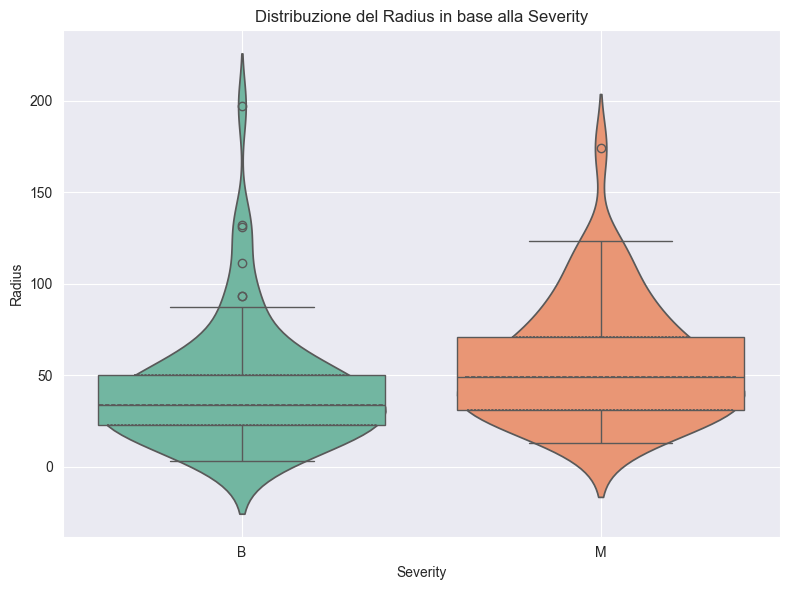

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.boxplot(x="Severity", y="Radius", data=df, hue="Severity", palette="Set2", legend=False)
sns.violinplot(x="Severity", y="Radius", data=df, hue="Severity", palette="Set2", inner="quartile", legend=False)
plt.title("Distribuzione del Radius in base alla Severity")
plt.xlabel("Severity")
plt.ylabel("Radius")
plt.grid(True)
plt.tight_layout()
plt.show()

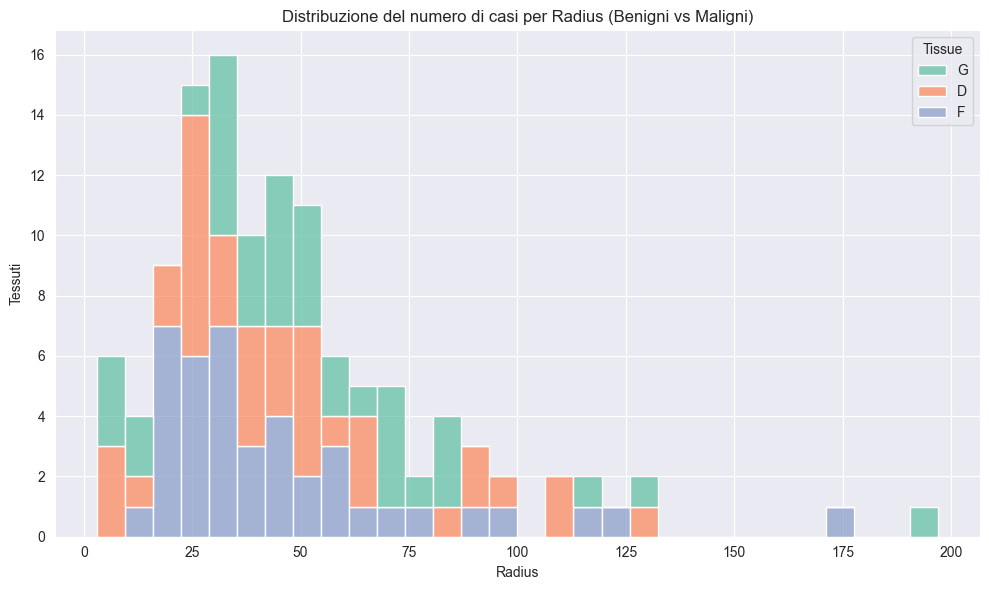

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Radius", hue="Tissue", bins=30, kde=False, multiple="stack", palette="Set2")

plt.title("Distribuzione del numero di casi per Radius (Benigni vs Maligni)")
plt.xlabel("Radius")
plt.ylabel("Tessuti")
plt.grid(True)
plt.tight_layout()
plt.show()

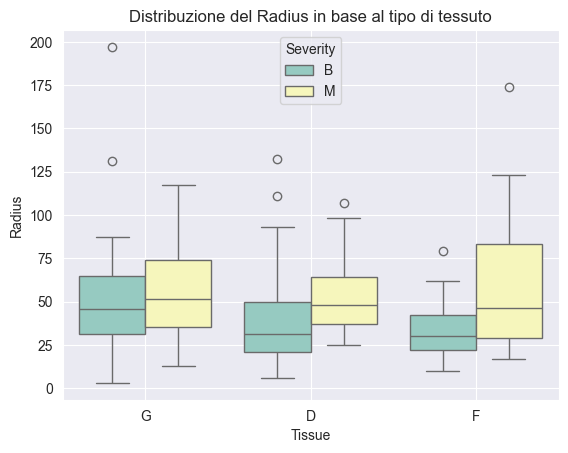

In [18]:
sns.boxplot(data=df, x="Tissue", y="Radius", hue="Severity", palette="Set3")
plt.title("Distribuzione del Radius in base al tipo di tessuto")
plt.grid(True)
plt.show()

Analisi sulla posizione del tumore

In [19]:

# Mantengo solo i casi con tumore (Severity B o M)
df = df.dropna(subset=['Severity'])

# Estraggo il numero da ID (es. mdb001 → 1) e determina il lato
df['ID_Num'] = df['ID'].str.extract(r'(\d+)').astype(int)
df['Lato'] = df['ID_Num'].apply(lambda n: 'sinistro' if n % 2 == 1 else 'destro')

conteggio_tumori_per_lato = df['Lato'].value_counts()

conteggio_per_lato_e_tipo = df.groupby(['Lato', 'Severity']).size().unstack(fill_value=0)

conteggio_tumori_per_lato, conteggio_per_lato_e_tipo

(Lato
 sinistro    63
 destro      60
 Name: count, dtype: int64,
 Severity   B   M
 Lato            
 destro    34  26
 sinistro  35  28)

In [20]:
print(df['Severity'].value_counts())

Severity
B    69
M    54
Name: count, dtype: int64


In [21]:
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
def quadrante(row):
    if row['X'] < 512 and row['Y'] < 512:
        return 'Q0'
    elif row['X'] >= 512 > row['Y']:
        return 'Q1'
    elif row['X'] < 512 <= row['Y']:
        return 'Q2'
    else:
        return 'Q3'
df['Quadrante'] = df.apply(quadrante, axis=1)
print(df['Quadrante'].value_counts())
tabella = df.groupby(['Quadrante', 'Severity']).size().unstack(fill_value=0)
print(tabella)

Quadrante
Q3    35
Q2    35
Q1    27
Q0    26
Name: count, dtype: int64
Severity    B   M
Quadrante        
Q0         16  10
Q1         18   9
Q2         15  20
Q3         20  15


In [22]:
# Tabella: Quadrante + Lato vs Severity
tabella = df.groupby(['Quadrante', 'Lato', 'Severity']).size().unstack(fill_value=0)
print(tabella)

Severity             B   M
Quadrante Lato            
Q0        destro     8   9
          sinistro   8   1
Q1        destro     4   1
          sinistro  14   8
Q2        destro    14  12
          sinistro   1   8
Q3        destro     8   4
          sinistro  12  11


Divisione per lato del seno

In [23]:

df['X_corr'] = df.apply(lambda row: 1024 - row['X'] if row['Lato'] == 'sinistro' else row['X'], axis=1)
df['Y_corr'] = df['Y']  
def quadrante_corr(row):
    if row['X'] < 512 and row['Y_corr'] < 512:
        return 'Q0'
    elif row['X'] >= 512 and row['Y_corr'] < 512:
        return 'Q1'
    elif row['X'] < 512 and row['Y_corr'] >= 512:
        return 'Q2'
    else:
        return 'Q3'

df['Quadrante_corr'] = df.apply(quadrante_corr, axis=1)
print(df['Quadrante_corr'].value_counts())

Quadrante_corr
Q3    35
Q2    35
Q1    27
Q0    26
Name: count, dtype: int64


In [24]:
tabella = df.groupby(['Quadrante_corr', 'Severity']).size().unstack(fill_value=0)
print(tabella)

Severity         B   M
Quadrante_corr        
Q0              16  10
Q1              18   9
Q2              15  20
Q3              20  15


Impostiamo una categoria a Radius in modo da poter raggruppare in modo equo tutte le istanze

In [25]:
df['RadiusBin'] = pd.qcut(df['Radius'], q=5, labels=['XS', 'S', 'M', 'L', 'XL'])
print(df['RadiusBin'].value_counts())


RadiusBin
XS    24
S     24
M     24
L     24
XL    23
Name: count, dtype: int64


In [27]:
tabella = df.groupby(['RadiusBin', 'Severity']).size()
print(tabella)

RadiusBin  Severity
XS         B           20
           M            4
S          B           14
           M           10
M          B           13
           M           11
L          B           12
           M           12
XL         B            9
           M           14
dtype: int64


/var/folders/8z/67y4_fv93g3dgx30jl7w8ss40000gn/T/ipykernel_1300/616619508.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabella = df.groupby(['RadiusBin', 'Severity']).size()


VERIFICA DELL?IMPORTANZA DI AREA

In [10]:
df['Area'] = np.pi * (df['Radius'] ** 2)
medvalue = df['Area'].mean()
medvalue2 = df['Area'].median()
print(f"Media dell'area: {medvalue:.2f}")
print(f"Mediaiana dell'area: {medvalue2:.2f}")

Media dell'area: 11004.79
Mediaiana dell'area: 5281.02


In [11]:
df['AreaAboveMean'] = df['Area'] > medvalue
table = pd.crosstab(df['Severity'], df['AreaAboveMean'])
table.columns = ['Sotto media', 'Sopra media']
print(table)

          Sotto media  Sopra media
Severity                          
B                  55           14
M                  34           20


In [12]:
tabella = df.groupby(['Tissue', 'Severity']).size()
print(tabella)

Tissue  Severity
D       B           23
        M           18
F       B           24
        M           19
G       B           22
        M           17
dtype: int64


In [13]:
tabella = df.groupby(['Class', 'Severity']).size()
print(tabella)

Class  Severity
ARCH   B            9
       M           10
ASYM   B            6
       M            9
CALC   B           15
       M           15
CIRC   B           21
       M            4
MISC   B            7
       M            8
SPIC   B           11
       M            8
dtype: int64


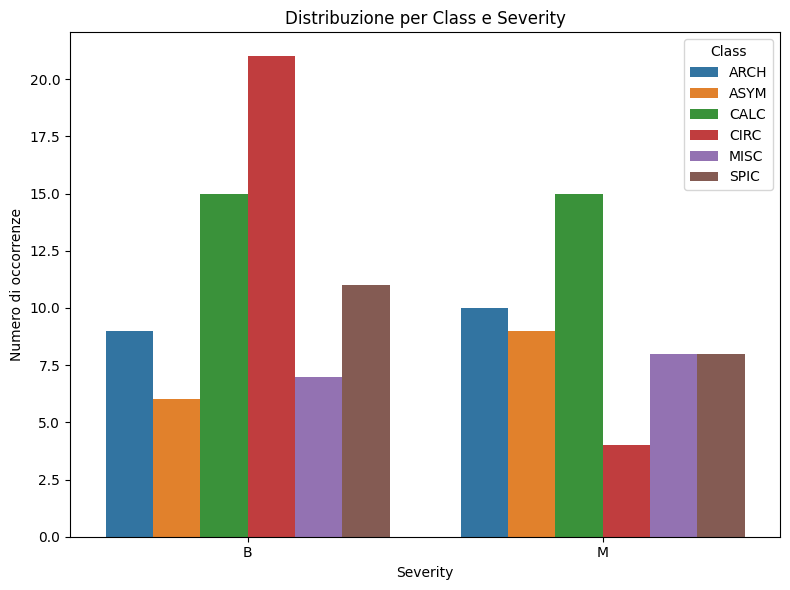

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tabella = df.groupby(['Class', 'Severity']).size().reset_index(name='Count')

plt.figure(figsize=(8, 6))
sns.barplot(data=tabella, x='Severity', y='Count', hue='Class')

plt.title('Distribuzione per Class e Severity')
plt.xlabel('Severity')
plt.ylabel('Numero di occorrenze')
plt.legend(title='Class')

plt.tight_layout()
plt.show()